# Práctica 6 - Clasificador de imágenes con redes neuronales

Una vez hayas terminado, descarga el notebook en formato ipynb y súbelo a Moodle en la tarea habilitada para la práctica con el nombre NIP_P6.ipynb

Es **obligatorio** que se **guarden los resultados de la evaluación** de cada celda de código (para no tener que volver a ejecutarlas). Por defecto los notebooks estan configurados así (Edit→Notebook Settings → NUNCA actives: Omit code cell output when saving this notebook)

La evaluación de la práctica se realizará mediante una entrevista durante la semana de evaluación continua en la que se deberá mostrar el funcionamiento del cuaderno de Colab y resolver a preguntas relacionadas con su contenido. Evaluación: funcionamiento de colab 50%. Respuesta a las preguntas 50% de la nota.

Imports necesarios para ejecutar el trabajo

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping
import time
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Generamos las listas con los parametros para despues mostrarlos y trabajar con ellos.

loss_list: Busca las claves que tengan la palabra "loss" pero no "val". Esto representa el Error de Entrenamiento.

val_loss_list: Busca las claves que tengan "loss" y "val". Esto es el Error de Validación.

acc_list: Busca las claves con "acc" pero no "val". Estos son los Aciertos de Entrenamiento.

val_acc_list: Busca las claves con "acc" y "val". Estos son los Aciertos de Validación.

Y con loss list y val loss list sacamos los fallos y para los aciertos acc list y val acc list.

In [2]:
def plot_history(history):
  loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
  val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
  acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
  val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

  if len(loss_list) == 0:
      print('Loss is missing in history')
      return

  ## As loss always exists
  epochs = range(1,len(history.history[loss_list[0]]) + 1)

  ## Loss
  fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
  for l in loss_list:
      axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
  for l in val_loss_list:
      axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

  axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
  axs[0].grid()
  axs[0].legend()

  ## Accuracy
  for l in acc_list:
      axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
  for l in val_acc_list:
      axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

  axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
  axs[1].grid()
  axs[1].legend()
  plt.show()

Carga del dataset MNIST
separandolo en entrenamiento y test.

In [3]:
verbose = True
use_CNN = True #Al no convolucionarlos los metemos en vector plano

print('Loading MNIST dataset...')
# Problem dimensions
img_rows, img_cols = 28, 28
num_pixels = img_rows * img_cols
num_classes = 10
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
if use_CNN:
  x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
  x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
  input_shape = (img_rows, img_cols, 1)
else: #Los pone planos de 28x28
  x_train = x_train.reshape(60000, num_pixels)
  x_test = x_test.reshape(10000, num_pixels)
#Los pasamos de 0 a 1 en vez de 0 a 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

np.random.seed(0)
p = np.arange(x_train.shape[0])
np.random.shuffle(p)
x_train = x_train[p]
y_train = y_train[p]


Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Ejemplo de definición de la arquitectura de una red y de los parámetros de la optimización.

In [4]:
# Función para parar cuando ya no mejora el error en los datos de validacion
#Al fallar 5 veces seguidas para
earlystop=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
model = Sequential()
if use_CNN:
  # Red convolucional
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
else:
  # Perceptron de un solo nivel
  #Hace funcion de 10 unicas neuronas metiendo los pixeles como entrada
  #Donde el sigmoid devuelve 1 o 0 en funcion de lo que devuelva el resultado de la neurona
  model.add(Dense(128, activation='relu', input_shape=(num_pixels,)))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(10, activation='softmax'))
#softmax peor para el sobre ajuste

model.compile(loss='categorical_crossentropy', optimizer=Adam(),  metrics=['accuracy'])
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

Código para entrenar la red neuronal utilizando la función FIT

Observa como incluye un argumento para hacer separación de datos de validación



Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.8389 - loss: 0.5045 - val_accuracy: 0.9825 - val_loss: 0.0636
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9708 - loss: 0.0930 - val_accuracy: 0.9860 - val_loss: 0.0477
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9807 - loss: 0.0657 - val_accuracy: 0.9868 - val_loss: 0.0423
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9845 - loss: 0.0503 - val_accuracy: 0.9855 - val_loss: 0.0460
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9876 - loss: 0.0414 - val_accuracy: 0.9893 - val_loss: 0.0381
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9875 - loss: 0.0379 - val_accuracy: 0.9895 - val_loss: 0.0392
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9906 - loss: 0.0308 - val_accuracy: 0.9905 - val_loss: 0.0352
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9910 - loss: 0.0274 - val_accuracy:

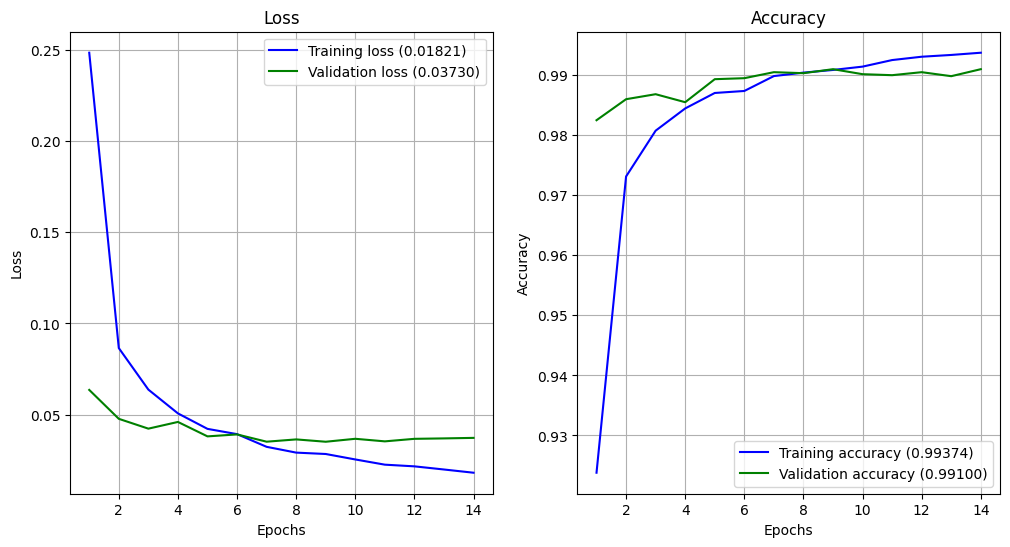

In [5]:
t0 = time.perf_counter()
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_split=0.1,
                    callbacks=[earlystop],
                    verbose=verbose)

train_time = time.perf_counter() - t0
print('%s %.3f%s' %  ('Training time: ', train_time, 's') )
plot_history(history)

## Preguntas a responder de la celda anterior


### 1 - ¿Qué representan los parámetros batch_size y epochs? (Respuesta dos líneas max).

Batch_size corresponde al tamaño de la muestra usada, en vez coger los 60000 de entrenamiento los divide en bloques de 128 para mediar la sol en vez de 1 en 1.
Por parte de epochs son las veces que repasa los datos ya vistos, seguro mientras tengamos el earlystop.

### 2 - Explica las dos gráficas que se muestran al finalizar el entrenamiento.

Se muestran 2 graficas
1 de porcentaje de fallos, que vemos como baja mientras siga entrenandose. Tanto por parte de los datos de entrenamiento como de verificacion. En cuanto los de verificacion encuentren un punto de inflexion minimamente grande parara, puesto que los de entrenamiento siempre mejoran pero si se estudian de mas puede generar un modelo poco generalizado y solo bueno para los patrones de entrada, de ahi el uso del earlystop
La otra es lo mismo pero al reves.

Evaluación de la red

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #plt.tight_layout()


def plot_mnist_confusion_matrix(y_test, y_pred, normalize=False):
    class_names=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    y_tst = [np.argmax(y) for y in y_test]
    y_prd = [np.argmax(y) for y in y_pred]

    cnf_matrix = confusion_matrix(y_tst, y_prd)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          normalize=normalize)

Generamos la matriz de confusion con los datos de test

Accuracy train:  99.84%
Accuracy test:   99.15%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion matrix, without normalization


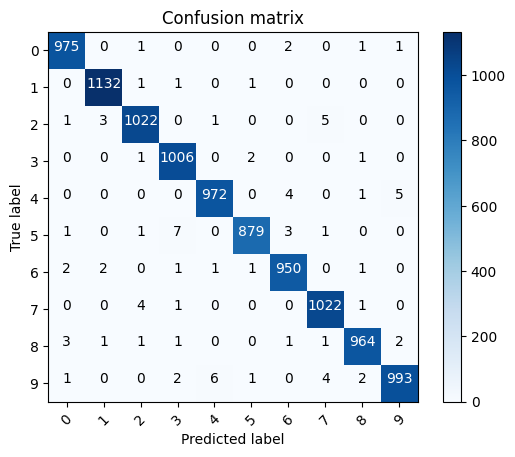

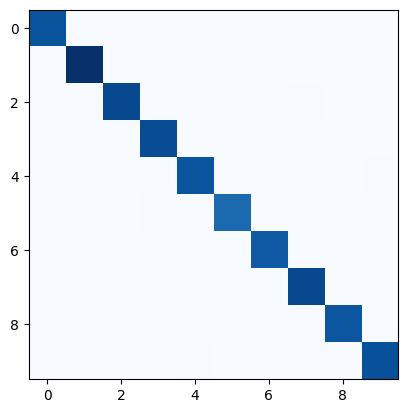

In [ ]:
# Evaluar la red
train_score = model.evaluate(x_train, y_train, verbose=0)
test_score = model.evaluate(x_test, y_test, verbose=0)
print('%s %2.2f%s' % ('Accuracy train: ', 100*train_score[1], '%' ))
print('%s %2.2f%s' % ('Accuracy test:  ', 100*test_score[1], '%'))

y_pred = model.predict(x_test)
plot_mnist_confusion_matrix(y_test, y_pred, normalize=False)
# Standard confusion matrix plot
cm=confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
plt.imshow(cm, cmap='Blues')

## Preguntas a responder de la celda anterior

### 3 - Explica la gráfica que se muestra

Muestra los valores como se reparten una vez probados, siendo la diagonal los aciertos y el resto de la linea o columna sus fallos. Siendo el eje horizontal la prediccion y el horizontal donde deberia de ir. Entonces los valores son correctos si coinciden en x e y con el mismo valor, si no es asi se tratara de un error. Lo que podemos ver es que se suele confundir el 9 y el 4 o el 7 y 2 puesto que su forma tiene mas parecido que con el resto, provocando que sea mas probable fallar en trazos mas parecidos.

## TRABAJO PRÁCTICO


**Trabajo práctico**: incluye a continuación las secciones de código para probar las diferentes redes.
No incluyas una sección para cada red que pruebes. El notebook que entregues deberá incluir:


4.1.   La mejor red obtenida para el caso de una capa

4.2.   La mejor red obtenida para el caso de dos capas

4.3.   La mejor red obtenida para el caso de tres capas

4.4.   Ejemplo de red en la que se produzca sobreajuste al entrenar

4.5.   Modificación de la red anterior utilizando técnicas para evitar el sobreajuste

4.6.   Ejecuta la red convolucional y compara el resultado con los obtenidos utilizando perceptrón.

4.7.   Incluye en una sección de texto una tabla en la que aparezca resumido el conjunto de pruebas realizado y los resultados obtenidos en cada caso (nº capas, nº neuronas, accuracy, técnicas de sobreajuste, etc.). Incluye en esta sección también las conclusiones obtenidas del trabajo.

4.8.   Recuerda mostrar y comentar algún ejemplo de imagen mal clasificada por la red que mejor se comporte.

4.9.   Opcional: Evalua el rendimiento de un MLP y una CNN en un dataset diferente (CIFAR10, CIFAR100, etc. Puedes ver más opciones de datasets para clasifición en imágenes en www.tensorflow.org/datasets/catalog/overview?hl=es)





---


# **4.1. La mejor red obtenida para el caso de una capa**
Para esta parte volveremos a entrenar el modelo pero acotado a una unica capa,
siguiendo a estructura del ejemplo. Dejamos la 10
Dejaremos el CNN false; e iremos cambiando entre sigmoid y softmax, y cambiaremos el algoritmo de optimizacion

# Para ambos con adam:

model.compile(loss='categorical_crossentropy', optimizer=Adam(),  metrics=['accuracy'])

  Para model.add(Dense(10, activation='sigmoid', input_shape=(num_pixels,)))
     Accuracy train:  93.29%    Accuracy test:   92.70%

  Para model.add(Dense(10, activation='softmax', input_shape=(num_pixels,)))
     Accuracy train:  93.30%    Accuracy test:   92.65%

# Para sgd:

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
      Accuracy train:  90.18%     Accuracy test:   90.76%

Puesto que da mucho menor es seguro que adam sera mucho mejor.

# Para rmsprop:

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
      Accuracy train:  90.15%Accuracy test:   90.82%

En teoria RMSprop no merecia la pena puesto que es anterior a adam, pero aun asi incluyo alguna prueva suya


Por todo lo anterior nos quedamos con adam con sigmoid en este caso, aunque la diferencia entre sigmoid y softmax sea infima.




---

# **4.2. La mejor red obtenida para el caso de dos capas**
  
#  Compararemos softmax y sigmoid para SGD, para ver cual es mejor:

  model.add(Dense(128, activation='relu', input_shape=(num_pixels,)))
  model.add(Dense(10, activation='sigmoid'))
  model.compile(loss='categorical_crossentropy', optimizer=SGD(),  metrics=['accuracy'])

Accuracy train:  93.41%
Accuracy test:   93.43%

  model.add(Dense(128, activation='relu', input_shape=(num_pixels,)))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=SGD(),  metrics=['accuracy'])

  Al ser este ultimo el mejor de SGD adjuntamos su grafica:
        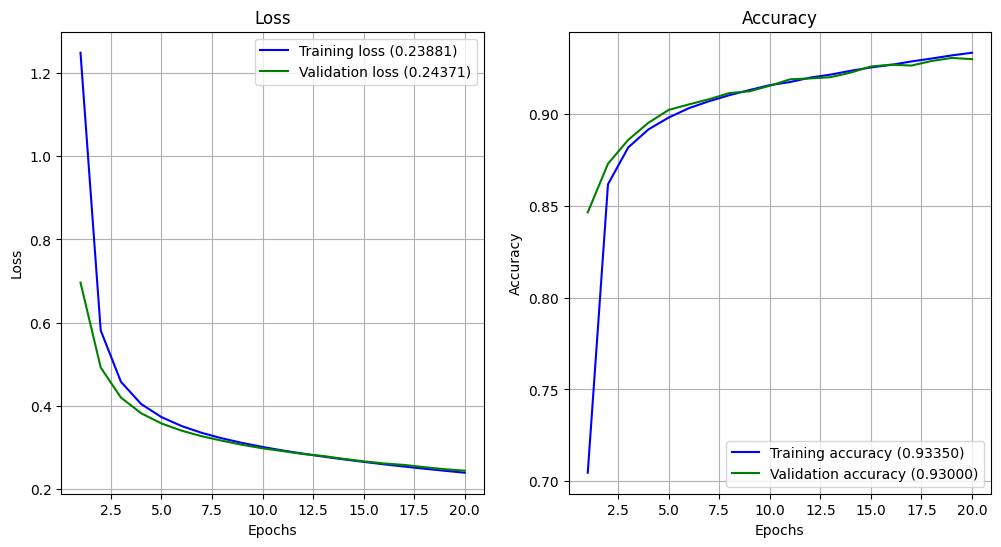
Accuracy train:  93.48%
Accuracy test:   93.53%

# De paso probamos Adam con sigmoid:
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='sigmoid', input_shape=(num_pixels,)))
  model.compile(loss='categorical_crossentropy', optimizer=Adam(),  metrics=['accuracy'])

  Vemos que lo revienta a SGD pero genera un poco de sobreajuste, pero aun asi sigue siendo mejor, veremos ahora la mejor configuracion de Adam.
        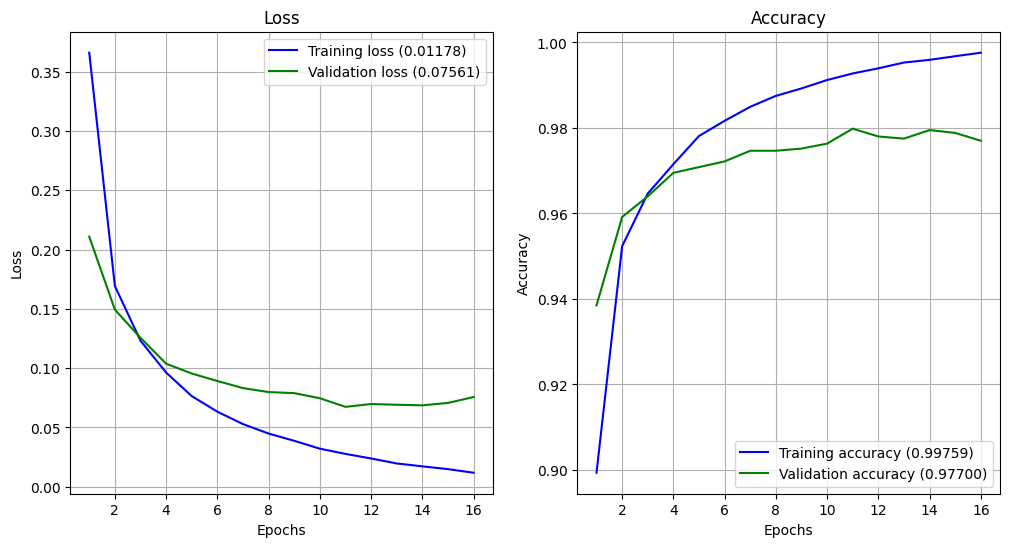
  Accuracy train:  99.59%
Accuracy test:   97.65%

y este mismo con softmax nos da:
Accuracy train:  99.74%
Accuracy test:   97.94%

Dandonos uno todavia mejor, nos quedamos con softmax, por lo cual ajustaremos ahora la cantidad de neuronas sobre este dandonos el mejor modelo.
  model.add(Dense(64, activation='relu', input_shape=(num_pixels,)))
  model.add(Dense(10, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer=Adam(),  metrics=['accuracy'])

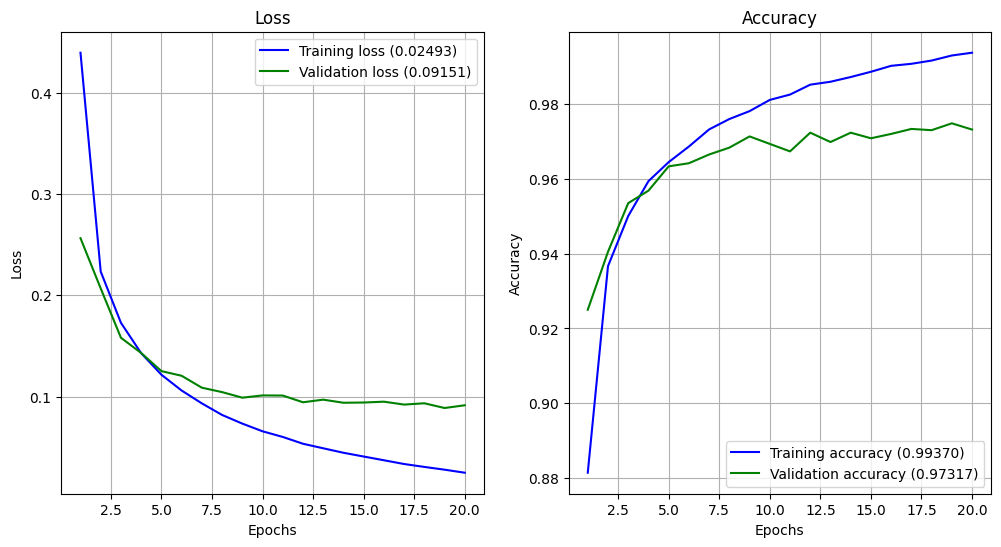

Vamos a quedarnos con las 128, puesto que con 64 el modelo pierde rendimiento, pero vamos a usar el model.add(Dropout(0.25)) que vemos en el ejemplo anterior para quitar el sobreajuste generado.

  model.add(Dense(128, activation='relu', input_shape=(num_pixels,)))
  model.add(Dropout(0.25))
  model.add(Dense(10, activation='softmax'))
  Accuracy train:  99.56%
Accuracy test:   98.10%
      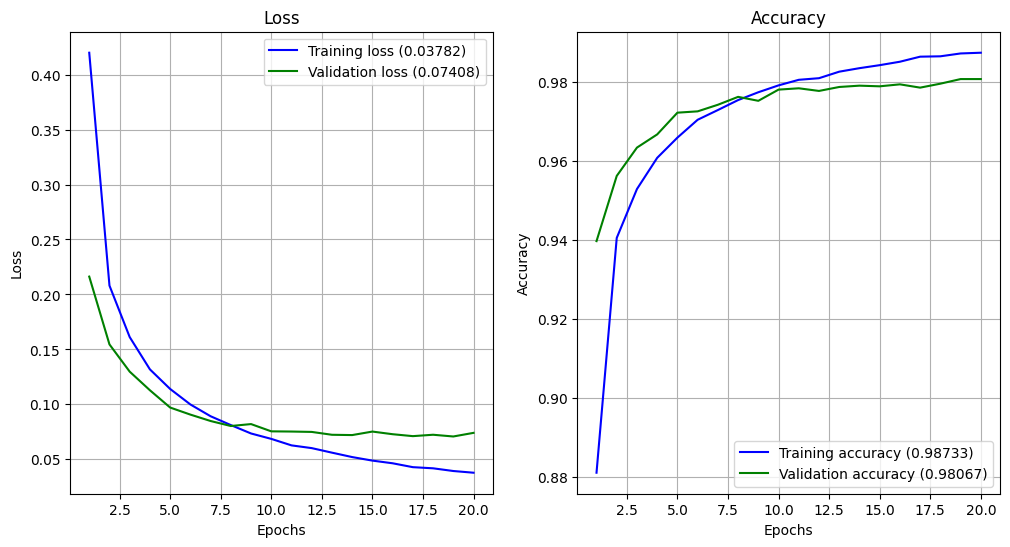


Por ultimo lo compararemos con 256 y con 512 y nos quedaremos con el mejor.

Para 256 obtenemos el mejor modelo hasta ahora, dejando la correcion de sobreajuste:

Accuracy train:  99.73%
Accuracy test:   98.24%

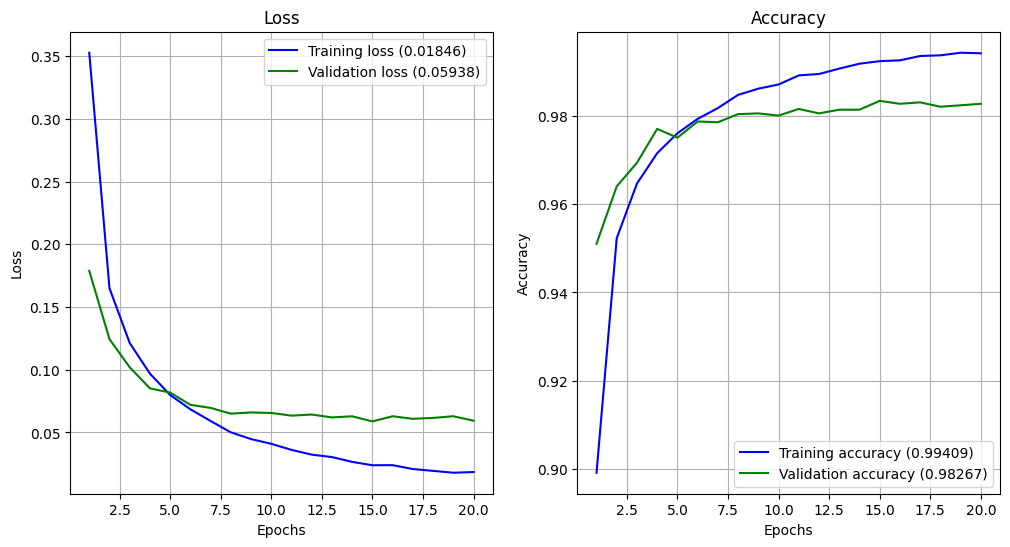

Y las 512

Accuracy train:  99.62%
Accuracy test:   98.15%

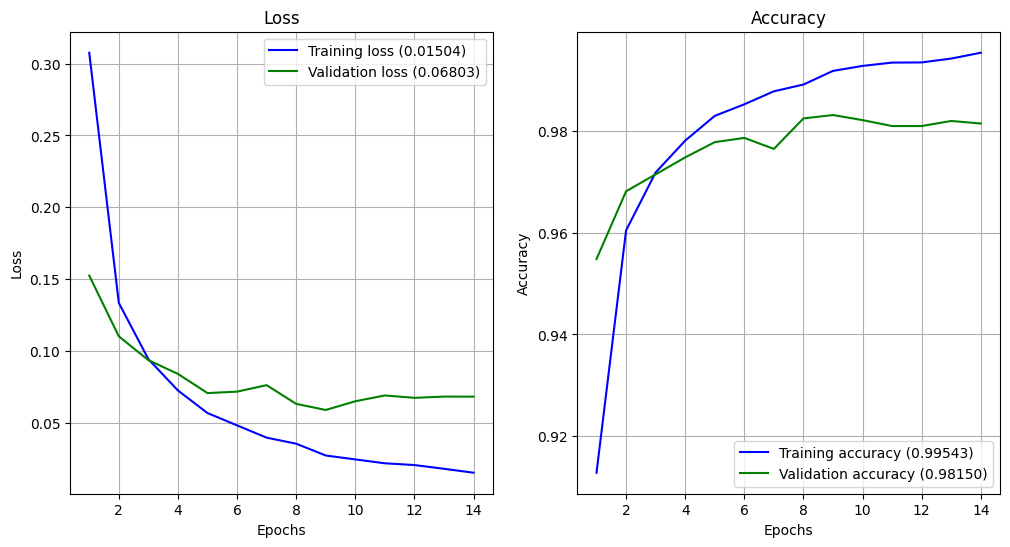
Vemos que para 512 neuronas ya empieza a perder, por lo cual nos quedamos con el modelo de 256 con Adam y softmax.




---


4.3. La mejor red obtenida para el caso de tres capas
  Ahora añadiremos a la capa anterior otra previa mas grande, probando las siguientes tres opciones
  model.add(Dense(256, activation='relu', input_shape=(num_pixels,)))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(10, activation='softmax'))

  Accuracy train:  99.61%
  Accuracy test:   98.06%


  model.add(Dense(128, activation='relu', input_shape=(num_pixels,)))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(10, activation='softmax'))

Accuracy train:  99.44%
Accuracy test:   97.86%


  model.add(Dense(512, activation='relu', input_shape=(num_pixels,)))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(10, activation='softmax'))

Accuracy train:  99.33%
Accuracy test:   97.91%

con sobre entrenamiento critico, ha saltado el earlystop en la mayoria de ellos



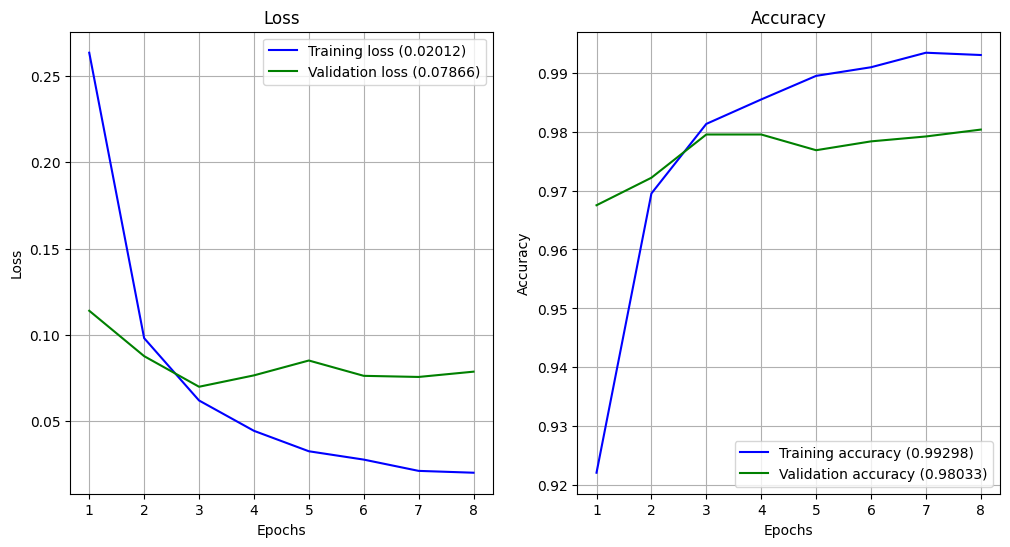


  model.add(Dense(128, activation='relu', input_shape=(num_pixels,)))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(10, activation='softmax'))


  Accuracy train:  99.47%
Accuracy test:   97.92%



---


4.4. Ejemplo de red en la que se produzca sobreajuste al entrenar
Por ejemplo tenemos el ejemplo critico anterior que provoco un early stop
model.add(Dense(256, activation='relu', input_shape=(num_pixels,))) model.add(Dense(128, activation='relu')) model.add(Dropout(0.25)) model.add(Dense(10, activation='softmax'))
o mismamente tambien el que corregimos inicialmente para hacer un modelo mejor:

Cito:
Dandonos uno todavia mejor, nos quedamos con softmax, por lo cual ajustaremos ahora la cantidad de neuronas sobre este dandonos el mejor modelo. model.add(Dense(64, activation='relu', input_shape=(num_pixels,))) model.add(Dense(10, activation='softmax')) model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

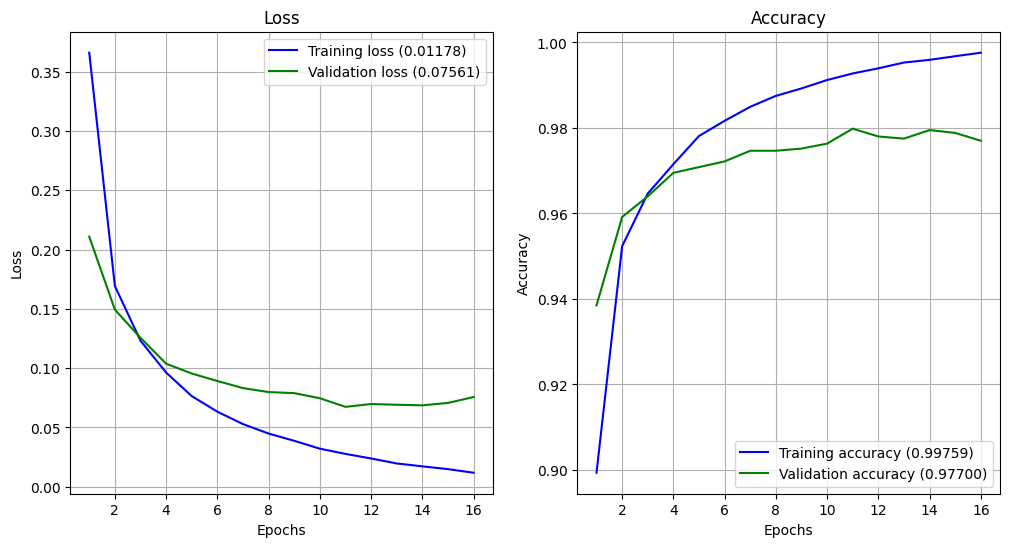




---


4.5. Modificación de la red anterior utilizando técnicas para evitar el sobreajuste
Donde le añadimos el dropout de 0.25 anteriormente, dejandonos:
model.add(Dense(128, activation='relu', input_shape=(num_pixels,))) model.add(Dropout(0.25)) model.add(Dense(10, activation='softmax')) Accuracy train: 99.56% Accuracy test: 98.10%

Si quisieramos reducirlo mas podriamos reducir la definicion de activacion del early stop para que saltara antes, siendo que a la minima concatenacion de no mejoras parara el entrenamiento.
Tambien en el earlystop podriamos añadir restore_best_weights=True para que una vez que pare las 5 regiones mas tarde de sobre ajuste se quede con el mejor modelo y no el ultimo.
Retrodecera y quitara ese sobre ajuste de las ultimas secciones que nos sobraba y no aportaba nada, el cual empeoraba el modelo. Quitando asi la ultima parte del sobreajuste detectado.

Cito:

Vamos a quedarnos con las 128, puesto que con 64 el modelo pierde rendimiento, pero vamos a usar el model.add(Dropout(0.25)) que vemos en el ejemplo anterior para quitar el sobreajuste generado.

model.add(Dense(128, activation='relu', input_shape=(num_pixels,))) model.add(Dropout(0.25)) model.add(Dense(10, activation='softmax')) Accuracy train: 99.56% Accuracy test: 98.10%

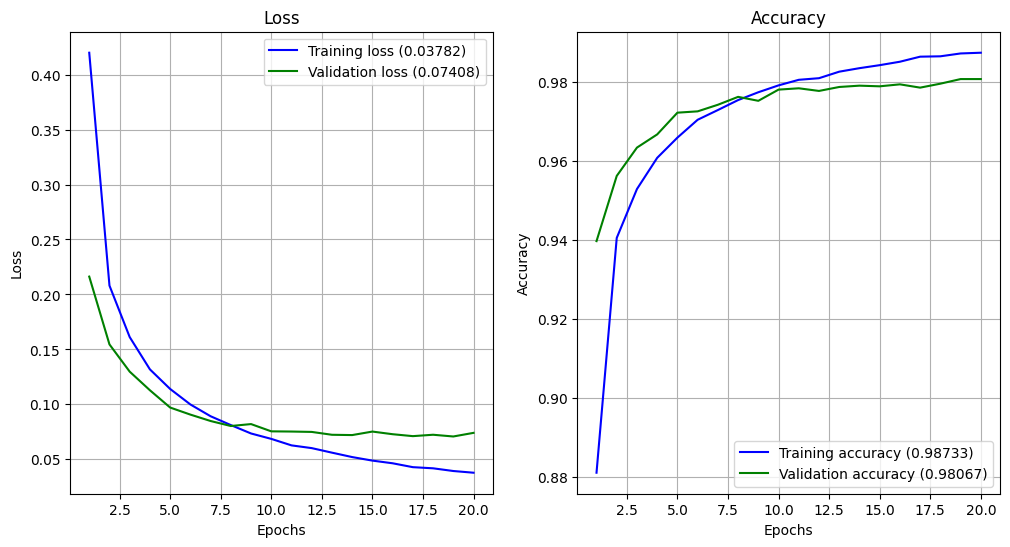

Como podemos ver la grafica ha mejorado gradualmente, la distancia entre la accuracy del entrenamiento y del test ya no es tan distante, ya no memoriza su entrenamiento y realmente se hace generico puesto que ambos ascienden de forma parecida.




---


4.6
Para este el experimento, cambiamos la arquitectura de un Perceptrón Multicapa (MLP) a una Red Neuronal Convolucional (CNN). en vez de tratar los datos como un vector normal usara la estructura espacial 2D de la imagen, permitiendo extraer características visuales como bordes y formas mediante filtros.

Con use_CNN = True en el código

Capas Convolucionales: Conv2D(32) y Conv2D(64) para extracción de características.

Pooling: MaxPooling2D para reducir la dimensionalidad y quedarse con la información relevante.

Clasificación: Flatten seguido de capas Dense con Dropout.


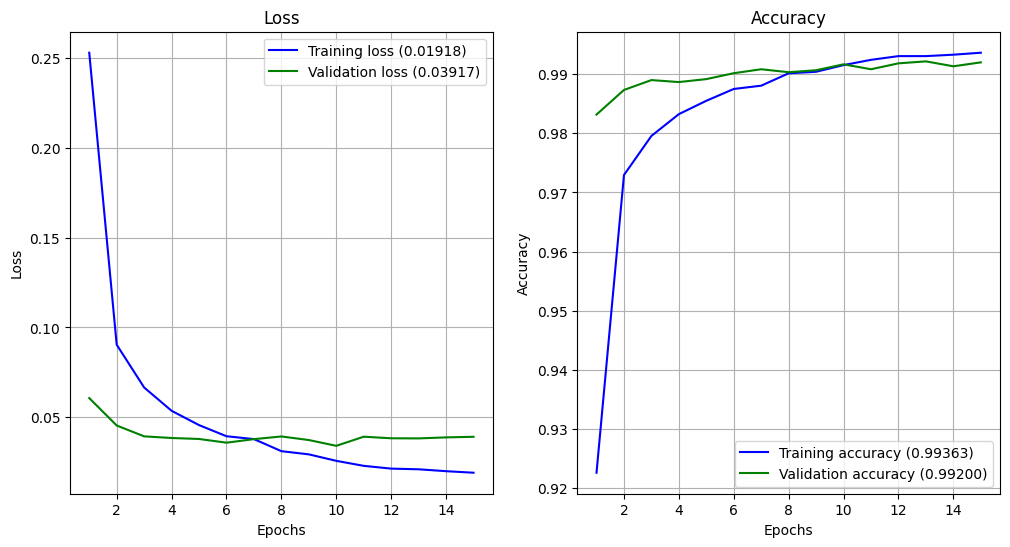

obteniendo asi un:
Accuracy train:  99.86%
Accuracy test:   99.18%

Comparativa con el Perceptrón (MLP): El mejor modelo MLP conseguido anteriormente ( con 128 neuronas y Dropout) alcanzó un 98.10% en test. La CNN ha logrado subir este resultado hasta el 99.18%. Reduciendo los fallos a más de la mitad (del ~1.9% de error al ~0.8%). Esto confirma que, para tareas de visión artificial como MNIST, las redes convolucionales son muy superiores, puesto que entiende la geometría de los números en vez de simplemente el vector.




---


4.7:

Modelo, Neuronas, Configuración,Accuracy Test, Tecnicas de sobreajuste, Observaciones


*   4.1: 1 Capa (Perceptrón Simple),Input → 10 (Softmax), Adam, 92.65%, EarlyStopping, No capta bien la complejidad.
*   4.2: 2 Capas (Mejor MLP),128 (ReLU) → 10 (Softmax),Adam, Dropout(0.25),98.10%, EarlyStopping, Dropout (0.25), Mejor equilibrio MLP. Mejora de calidad respecto a 1 capa.
*   4.3: 3 Capas,256 → 128 → 10 (Softmax),Adam, Dropout(0.25), 98.06%, EarlyStopping, Dropout (0.25),  Aumentar las capas no mejoraron al modelo de 2 capas.
*   4.4: Caso Sobreajuste,128 → 10 (Sigmoid),Adam, para el test97.9%, solo early stop sin drop, El modelo memoriza el train (99.7%) pero falla más en test real.
*   4.6: CNN (Convolucional),Conv32 → Conv64 → MaxPool,Adam,Dropout + Pooling,99.18%,Dropout y Pooling, Mejor Resultado. Supera la barrera del 99% gracias al análisis 2D.

el CNN gana: esta es la más adecuada para clasificación de imágenes. Al procesar la matriz 2D y filtros, esta obtiene el mayor porcentaje de acierto por parte del test.

En las pruebas iniciales 4.1 y 4.2, se observó una diferencia drástica entre SGD (~90-93%) y Adam (~92-98%). Adam converge mucho más rápido y consigue mejores mínimos en este problema. Ademas en los siguientes al trabajar mejor, obtenia un poco de sobreajuste con la misma cantidad de datos.

Ademas vimos como añadir más capas no siempre es mejor. El paso de 1 a 2 capas fue fundamental (de 92% a 98%), pero pasar de 2 a 3 capas (Apartado 4.3) apenas afectó al resultado e incluso lo empeoró ligeramente en algunos casos (98.06% vs 98.10%). El modelo de 2 capas ocultas,256 → 128 → 10 demostró ser el más eficiente de los MLP.

El uso de Dropout fue clave para estabilizar los modelos de (como el de 128 o 256 neuronas), permitiendo que generalizaran mejor. Además, configurar el EarlyStopping (idealmente con restore_best_weights=True) evita que el modelo se degrade en las últimas épocas de entrenamiento, en caso de que salte el early stop.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


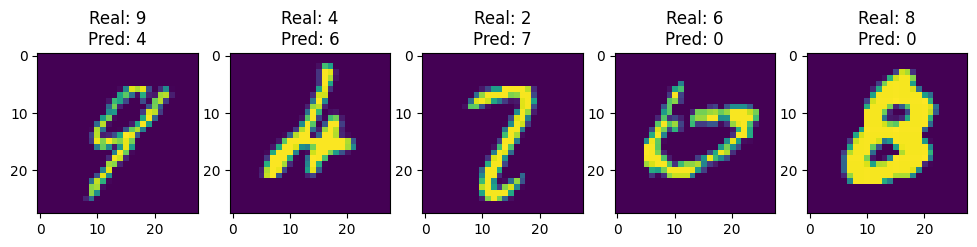

In [7]:
#4.8
predicciones = model.predict(x_test)
contador = 0
plt.figure(figsize=(12, 4))
i = 0
#Recorremos todas las imágenes del test una a una
while i < len(x_test) and contador < 5:
    # Sacamos quién es el mas probable
    prediccion = np.argmax(predicciones[i])
    # Sacamos quién es el real
    real = np.argmax(y_test[i])
    #Al no coincidir se genera el error
    if prediccion != real:
        contador += 1
        ax = plt.subplot(1, 5, contador) # Crear hueco para la imagen

        # Dibujamos
        img = x_test[i].reshape(28, 28)
        plt.imshow(img)
        plt.title(f"Real: {real}\nPred: {prediccion}")
    i += 1
plt.show()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 168s 1us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.2480 - loss: 2.2306 - val_accuracy: 0.3372 - val_loss: 1.8538
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3445 - loss: 1.8317 - val_accuracy: 0.3798 - val_loss: 1.7392
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3645 - loss: 1.7713 - val_accuracy: 0.3890 - val_loss: 1.7087
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3748 - loss: 1.7506 - val_accuracy: 0.4212 - val_loss: 1.6590
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3854 - loss: 1.7114 - val_accuracy: 0.4304 - val_loss: 1.6290
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3968 - loss: 1.6890 - val_accuracy: 0.4234 - val_loss: 1.6249
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4027 - loss: 1.6713 - val_accuracy: 0.4432 - val_loss: 1.6002
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4038 - loss: 1.6738 - val_accuracy: 0

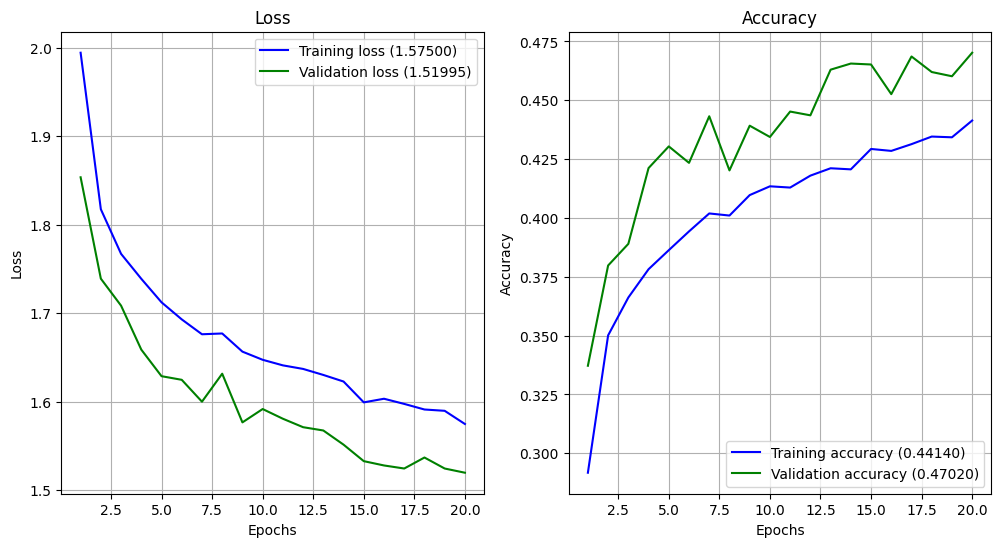

Accuracy mpl test:   46.69%
Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.2920 - loss: 1.9147 - val_accuracy: 0.5294 - val_loss: 1.3410
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4930 - loss: 1.4028 - val_accuracy: 0.5998 - val_loss: 1.1793
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5585 - loss: 1.2434 - val_accuracy: 0.6144 - val_loss: 1.1232
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5901 - loss: 1.1628 - val_accuracy: 0.6478 - val_loss: 1.0136
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6131 - loss: 1.0899 - val_accuracy: 0.6686 - val_loss: 0.9713
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6342 - loss: 1.0274 - val_accuracy: 0.6768 - val_loss: 0.9331
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6469 - loss: 0.9867 - val_accuracy: 0.6800 - val_loss: 0.9152
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6543 - l

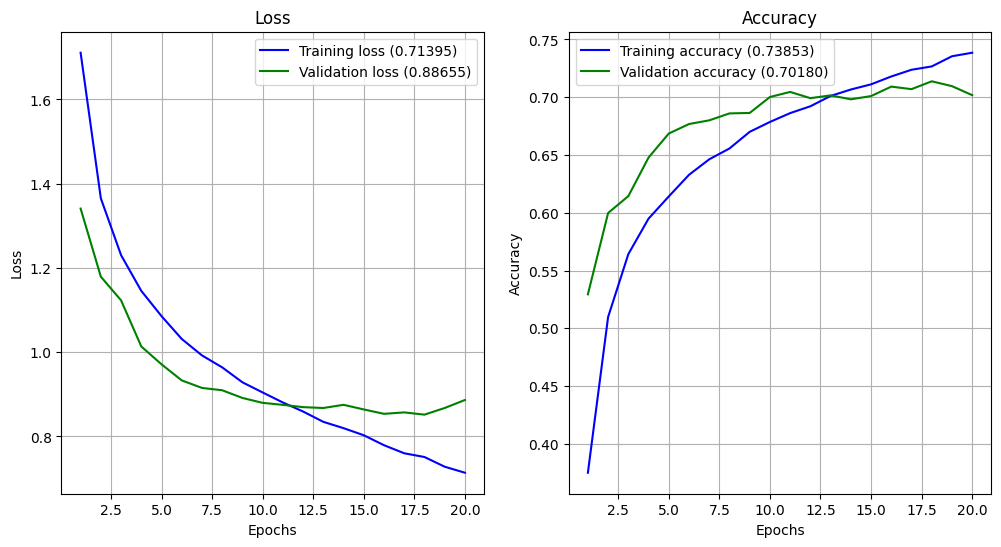

Accuracy cnn test:   68.71%


In [8]:
from keras.datasets import cifar10
# Usamos nombres distintos (xc_train) para no machacar los de MNIST
(xc_train, yc_train), (xc_test, yc_test) = cifar10.load_data()
# Normalizamos y categorizamos igual que en el archivo dado
xc_train = xc_train.astype('float32') / 255
xc_test = xc_test.astype('float32') / 255
yc_train = keras.utils.to_categorical(yc_train, 10)
yc_test = keras.utils.to_categorical(yc_test, 10)

#rendimiento de MLP y una CNN
model = Sequential()
#Aqui cambia el input_shape porque son 32x32 y 3 canales de color
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))
#usamos el mismo compile y fit que en los ejercicios anteriores
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Reutilizamos earlystop
history = model.fit(xc_train, yc_train,
                    batch_size=128,
                    epochs=20, # Ponemos 20 y que corte el earlystop
                    validation_split=0.1,
                    callbacks=[earlystop],
                    verbose=1) # Ponemos 1 para ver la barra

#LLamamos a mostrar
plot_history(history)

# Evaluamos como nos siempre
score = model.evaluate(xc_test, yc_test, verbose=0)
print('%s %2.2f%s' % ('Accuracy mpl test:  ', 100*score[1], '%' ))


#Lo mismo pero para el CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) # Un poco mas de dropout aqui
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Mismo entrenamiento
history = model.fit(xc_train, yc_train,
                    batch_size=128,
                    epochs=20,
                    validation_split=0.1,
                    callbacks=[earlystop],
                    verbose=1)

plot_history(history)

score = model.evaluate(xc_test, yc_test, verbose=0)
print('%s %2.2f%s' % ('Accuracy cnn test:  ', 100*score[1], '%' ))


Entrenando CNN 'VGG Style' (Más profunda)...
Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.2383 - loss: 2.0023 - val_accuracy: 0.5054 - val_loss: 1.3471
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5071 - loss: 1.3662 - val_accuracy: 0.5824 - val_loss: 1.1730
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5870 - loss: 1.1632 - val_accuracy: 0.6638 - val_loss: 0.9329
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6380 - loss: 1.0191 - val_accuracy: 0.6878 - val_loss: 0.8961
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.6680 - loss: 0.9410 - val_accuracy: 0.7176 - val_loss: 0.8005
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6900 - loss: 0.8842 - val_accuracy: 0.7356 - val_loss: 0.7585
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7092 - loss: 0.8309 - val_accuracy: 0.7412 - val_loss: 0.7403
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - a

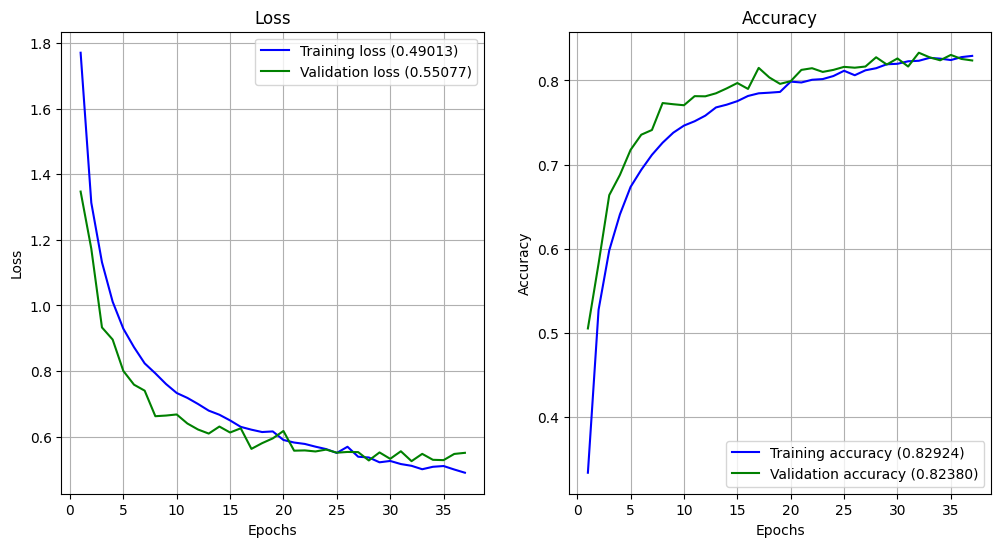

Accuracy CNN Potente:  81.31%


In [ ]:
# Con los contenidos vistos y lo que investigue vamos a intentar hacer un modelo más profundo y formal.
#En teoria los bloques de doble convolución para ganar "inteligencia" antes de reducir la imagen vendrian muy bien para este caso.
model = Sequential()

#Extracción de detalles al encadenar dos convoluciones seguidas antes del Pooling, aumentamos la capacidad de la red para entender características complejas (doble ReLU) sin reducir drásticamente el tamaño de la imagen antes de que le de tiempo a entrenarse bien.
#Donde a medida que la imagen se hace más pequeña (por los MaxPool), aumentamos el número de filtros (profundidad) para condensar información y equilibrar las perdidas.
# Y aumentamos la agresividad del borrado (0.25 -> 0.4 -> 0.5) en las capas profundas y densas, donde hay más parámetros y el riesgo de sobreajuste es mayor.
# usando 'same' mantenemos el tamaño (32x32) tras las convoluciones y que no desaparezca la imagen.
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) # Doble capa para más no-linealidad
model.add(MaxPooling2D(pool_size=(2, 2))) # Reducimos a 16x16
model.add(Dropout(0.25)) # Tiramos datos suavemente

#Patrones medios
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2))) # Reducimos a 8x8
model.add(Dropout(0.25))

#Patrones complejos
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2))) # Reducimos a 4x4
model.add(Dropout(0.4)) # Aumentamos dropout al tener más neuronas y riesgo de memorización

model.add(Flatten()) # Aplanamos los mapas de características 4x4x128 a un vector
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) # Dropout agresivo en la capa densa final
model.add(Dense(10, activation='softmax')) #Resultado final

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Usamos batch_size=64 para grupos de datos mas pequeños
history = model.fit(xc_train, yc_train,
                    batch_size=64,
                    epochs=50, # esperaremos el earlystop
                    validation_split=0.1,
                    callbacks=[earlystop],
                    verbose=1)

plot_history(history)

score = model.evaluate(xc_test, yc_test, verbose=0)
print('%s %2.2f%s' % ('Accuracy CNN Potente: ', 100*score[1], '%' ))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


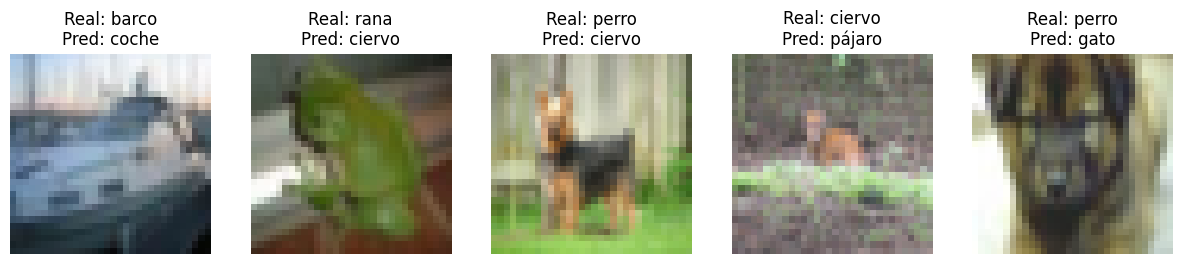

In [ ]:
#Y como ya hemos aprendido vemos los fallos
cifar_labels = ['avión', 'coche', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión']

# Obtenemos predicciones del ultimo modelo (la CNN)
predicciones = model.predict(xc_test)
i = 0
contador = 0
plt.figure(figsize=(15, 4))
# Bucle while igual que en el apartado 4.8
while i < len(xc_test) and contador < 5:
    # Sacamos ganador y real
    prediccion = np.argmax(predicciones[i])
    real = np.argmax(yc_test[i])
    # Si fallamos
    if prediccion != real:
        contador += 1
        ax = plt.subplot(1, 5, contador)
        # Mostramos imagen (CIFAR ya tiene color, no necesita reshape)
        plt.imshow(xc_test[i])
        # Ponemos el nombre en vez del numero
        txt_real = cifar_labels[real]
        txt_pred = cifar_labels[prediccion]
        plt.title(f"Real: {txt_real}\nPred: {txt_pred}")
        plt.axis("off")
    i += 1
plt.show()